# Кластеризация

Цель: Необходимо провести сегментацию клиентов для выделения различных групп.

Данные: Дана таблица клиентов с различной информацией относительно предпочтений покупок, частоты и сумм. 

## Выгрузка данных

Импортимпортируем нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import seaborn as sns

Создадим датафрем с данными и выведем на экран.

In [2]:
for_clustering = pd.read_excel('for_clustering.xlsx')

In [3]:
for_clustering.info()
for_clustering.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27508 entries, 0 to 27507
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id_client                 27508 non-null  int64  
 1   InWeek_amount             27508 non-null  float64
 2   InWeek_SKU                27508 non-null  int64  
 3   Checkinmonth_average      27508 non-null  int64  
 4   Checkamount_mean          27508 non-null  float64
 5   Count_transac             27508 non-null  int64  
 6   Total_amount              27508 non-null  float64
 7   Total_SKU_qnt             27508 non-null  int64  
 8   Count_departments         27508 non-null  int64  
 9   Count_shop                27508 non-null  int64  
 10  Count_city                27508 non-null  int64  
 11  Tenure                    27508 non-null  int64  
 12  SKU_meanbytransac         27508 non-null  int64  
 13  Amount_last6mnth          27508 non-null  float64
 14  Check_

,Id_client,InWeek_amount,InWeek_SKU,Checkinmonth_average,Checkamount_mean,Count_transac,Total_amount,Total_SKU_qnt,Count_departments,Count_shop,...,Cat_babyprod_qnt,Cat_babyprod_amount,Cat_babyprod_share,Communication_3month,Response_communcation,SKU_LastMonthqnt,Checks_LastMonthqnt,Amount_LastMonth,Discount,Discount_LastMonth
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,...,80,1004.370,0.081007,1,1,60,12,963.01,1,1
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,...,46,476.475,0.036766,1,0,91,15,1534.69,1,1
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,...,17,334.840,0.112974,1,1,13,2,1514.48,1,1
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,...,64,539.250,0.027406,1,0,68,35,1872.24,1,1
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,...,11,106.210,0.042788,1,1,22,3,557.97,1,1


Можно заметить, что названия столбцов начинаются с большой буквы, для удобства сделаем их с маленькой.

## Предобработка данных

In [4]:
for_clustering.columns = for_clustering.columns.str.lower()

Проверим на наличие дубликатов

In [5]:
for_clustering.duplicated().sum()

0

Дубликатов нет, теперь проверим на наличие пустых значений

In [6]:
for_clustering.isna().sum() / for_clustering.count() * 100

id_client                   0.000000
inweek_amount               0.000000
inweek_sku                  0.000000
checkinmonth_average        0.000000
checkamount_mean            0.000000
count_transac               0.000000
total_amount                0.000000
total_sku_qnt               0.000000
count_departments           0.000000
count_shop                  0.000000
count_city                  0.000000
tenure                      0.000000
sku_meanbytransac           0.000000
amount_last6mnth            0.000000
check_qntlast6mnth          0.000000
sku_price_mean              0.000000
gender                      0.883852
age                         0.555637
age_group                   0.555637
interval_visit              0.000000
days_pastvisit              0.000000
cat_householdchem_qnt       0.000000
cat_householdchem_amount    0.000000
cat_householdchem_share     0.000000
cat_careproducts_qnt        0.000000
cat_careproducts_amount     0.000000
cat_careproducts_share      0.000000
c

Есть пустые значения в 3 столбцах, но их меньше 1 процента, поэтому удалим их и это пркатически никак не повлияет на результат. Они могла возникнуть в результате того, что пользователи не хотели указывать свои данные.

In [7]:
for_clustering = for_clustering.dropna()

Так же можем ззаметить, что 2 столбца имеют тип object, но мы можем заменить их  на int.

In [8]:
for_clustering['gender'].unique()

array(['F', 'M'], dtype=object)

Заменим F на 0, а M на 1

In [9]:
def gender_to_int(value):
    if value == 'F':
        return 0
    else:
        return 1        

In [10]:
for_clustering['gender'] = for_clustering['gender'].apply(gender_to_int)

Теперь посмотрим на возрастные категории

In [11]:
for_clustering['age_group'].value_counts()

25-35    7121
35-45    6875
45-55    4941
55-65    4071
65+      2354
0-25     1905
Name: age_group, dtype: int64

Заменим 0-25 на 0, 25-35 на 1, 35-45 на 2, 45-55 на 3, 55-65 на 4, 65+ на 5

In [12]:
def age_group_to_int(value):
    if value =='0-25':
        return 0
    if value == '25-35':
        return 1
    if value == '35-45':
        return 2
    if value == '45-55':
        return 3
    if value == '55-65':
        return 4
    else:
        return 5

In [13]:
for_clustering['age_group'] = for_clustering['age_group'].apply(age_group_to_int)

## Кластеризация

Теперь посмторим матрицу корреляции, чтобы убрать из таблицы один из коррелирующих признаков. Будем считать признаками все столбцы, кроме id_client

In [14]:
cm = for_clustering.corr()

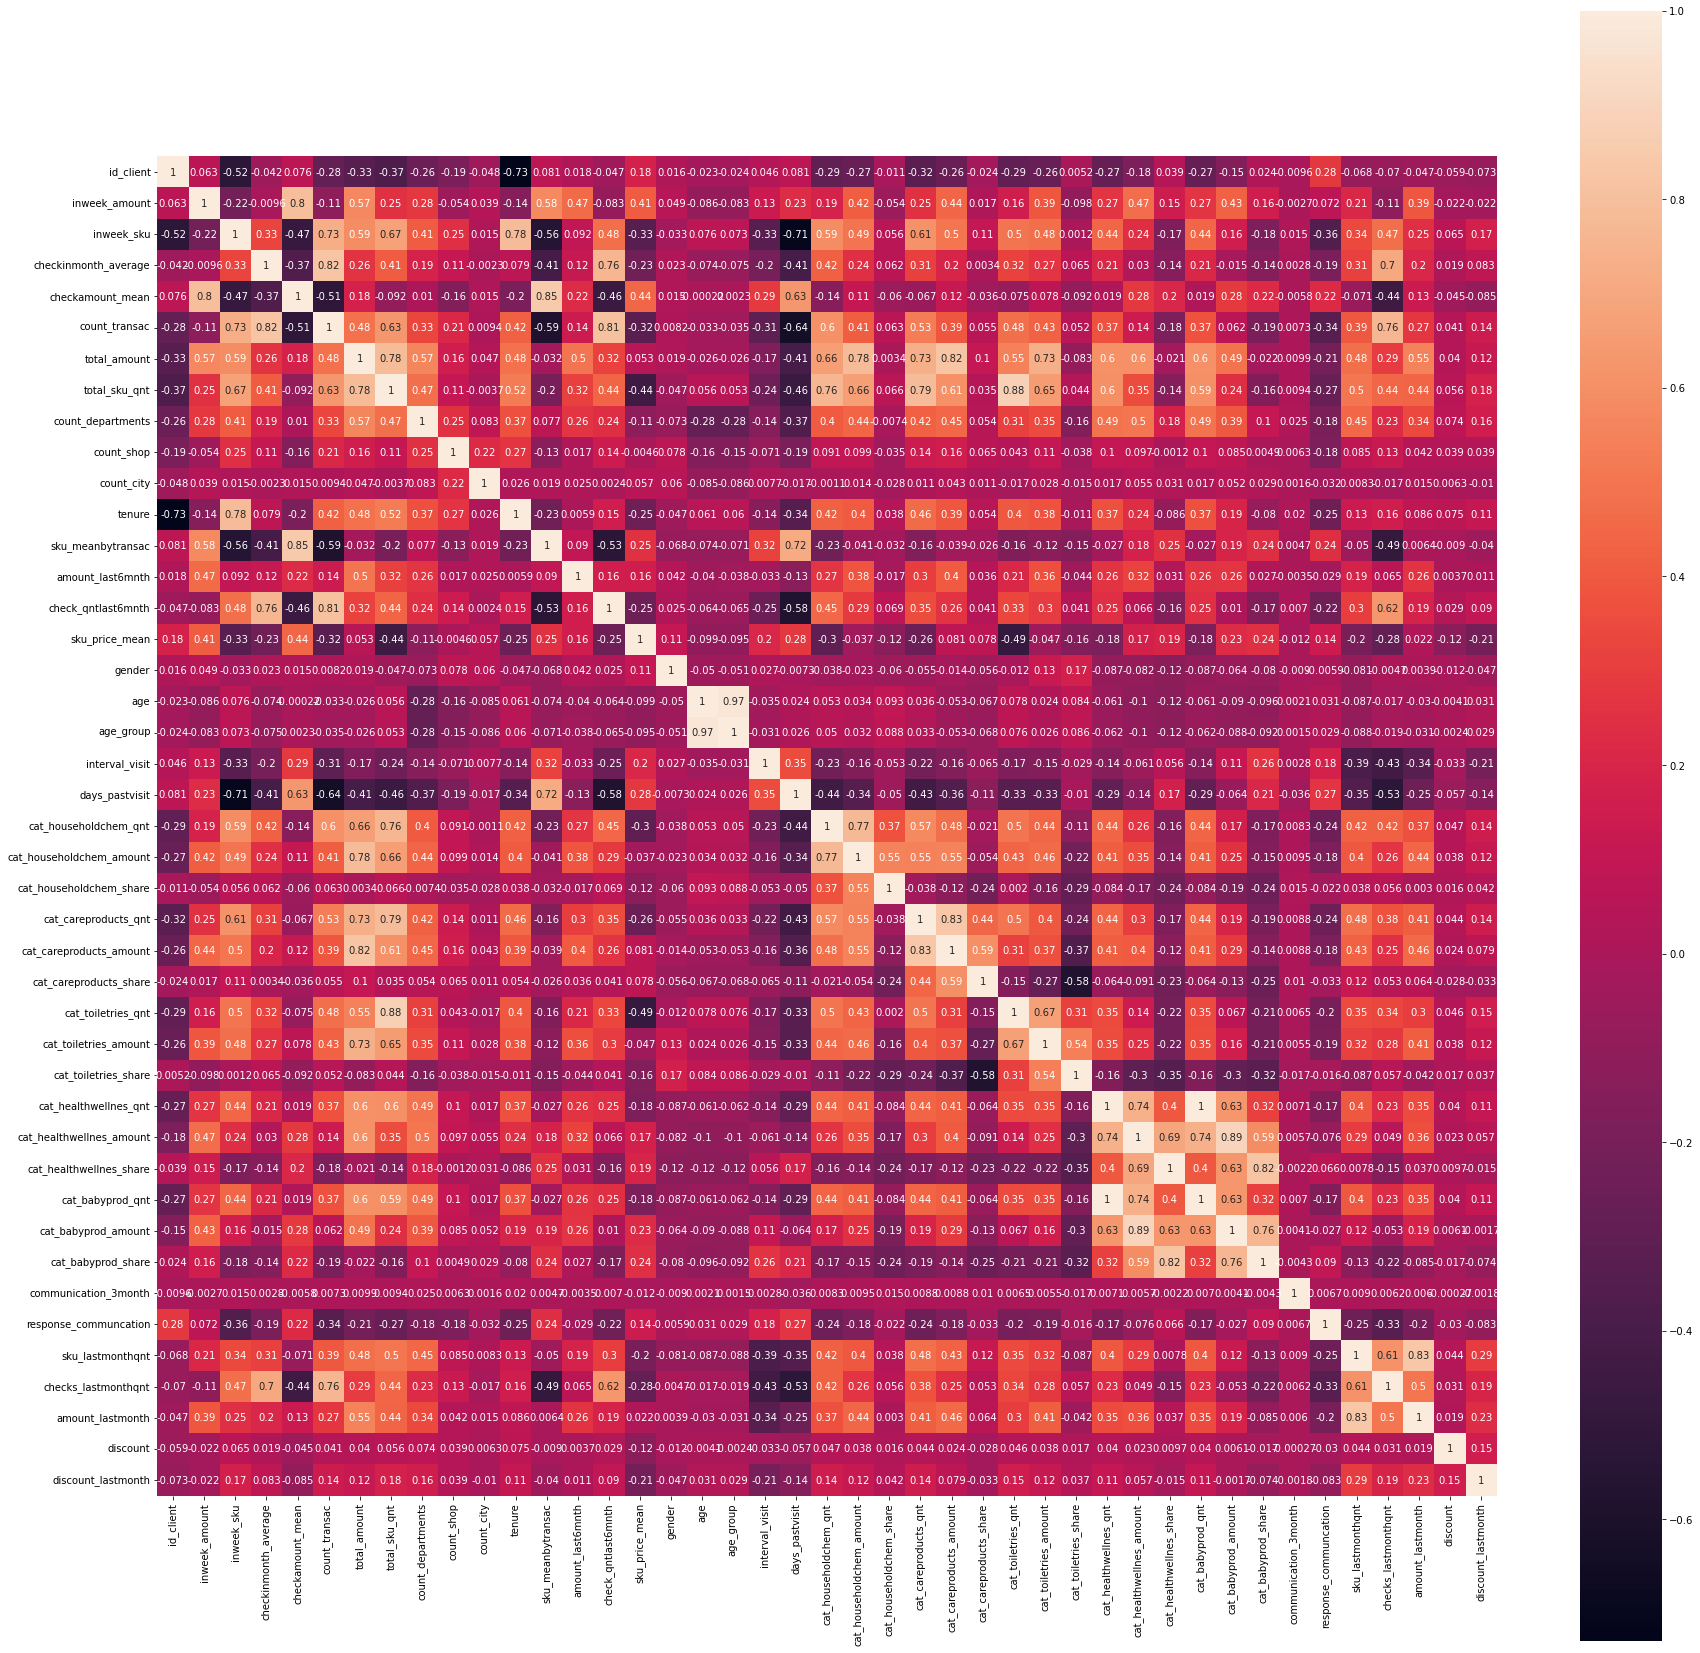

In [15]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(cm, annot=True, square=True)
plt.show()

In [16]:
X = for_clustering.drop(['id_client', 'inweek_sku', 'checkinmonth_average', 'count_transac',\
                         'total_amount', 'total_sku_qnt', 'sku_meanbytransac', 'cat_householdchem_qnt',\
                         'cat_careproducts_qnt', 'cat_healthwellnes_amount', 'cat_healthwellnes_share',\
                         'cat_babyprod_amount', 'sku_lastmonthqnt'], axis=1)   

Чтобы определить количество кластеров, сделаем иерархическую кластеризацию и построим дендограмму. Так как у нас много данных, для построения дендограммы сделаем случайную выборку из 1000 значений 

In [17]:
X_sample = X.sample(n=1000, random_state=0)

Стандартизируем данные

In [18]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_sample)

И нарисуем дендограмму. Поскольку у нас в условии не написан порог расстояний, перестанем объеденять кластеры на расстоянии 40.

In [19]:
linked = linkage(X_sc, method = 'ward') 

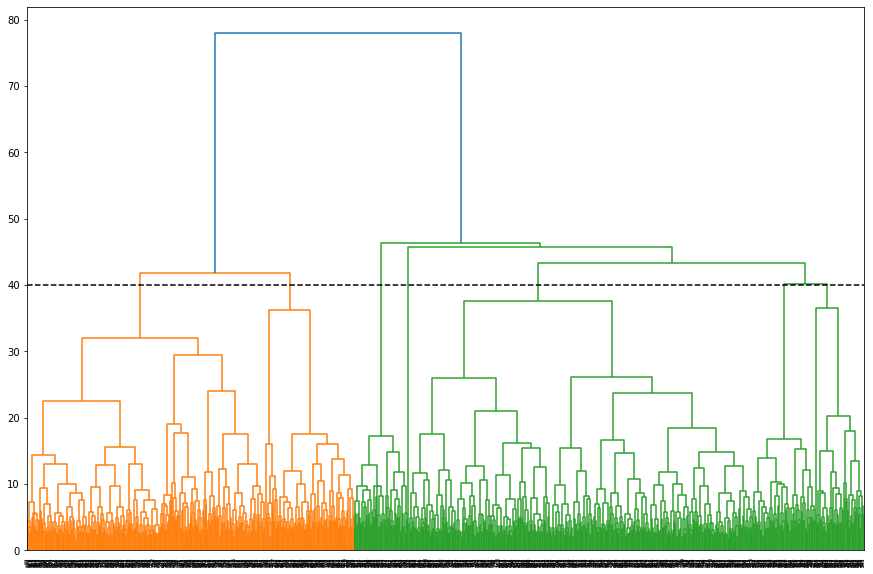

In [20]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y=40, color='black', linestyle='--')
plt.show() 

Пунктирной линией пересекаются 7 линии, следовательно будем делить на 7 кластеров.

Обучим модель кластеризации на основании алгоритма K-Means. Разделим на 7 кластеров

Опять стандартизируем данные, но уже все данные

In [21]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [22]:
km = KMeans(n_clusters = 7)
labels = km.fit_predict(X_sc)

И сохраним номер кластера в датасете

In [23]:
for_clustering['cluster'] = labels

In [24]:
for_clustering.head(5)

,id_client,inweek_amount,inweek_sku,checkinmonth_average,checkamount_mean,count_transac,total_amount,total_sku_qnt,count_departments,count_shop,...,cat_babyprod_amount,cat_babyprod_share,communication_3month,response_communcation,sku_lastmonthqnt,checks_lastmonthqnt,amount_lastmonth,discount,discount_lastmonth,cluster
0,5743,269.5328,46,2,102.9252,119,12398.51,1114,26,4,...,1004.370,0.081007,1,1,60,12,963.01,1,1,2
1,5756,359.9902,36,4,100.2813,130,12959.65,1024,29,3,...,476.475,0.036766,1,0,91,15,1534.69,1,1,2
2,5781,329.3200,9,4,102.2027,29,2963.88,170,24,1,...,334.840,0.112974,1,1,13,2,1514.48,1,1,6
3,5801,385.8105,51,8,48.8550,404,19676.34,2486,33,3,...,539.250,0.027406,1,0,68,35,1872.24,1,1,3
4,5808,310.2800,8,4,108.5789,25,2482.24,255,26,2,...,106.210,0.042788,1,1,22,3,557.97,1,1,6


## Вывод

После предобработки данных, с помощью иерархической кластеризации решил делить клиентов на 7 групп и с помощью алгоритма K-Means выполнил задание и добавил номер кластера в основной датасет.